In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Layer
from sklearn.preprocessing import StandardScaler
import warnings
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.optimizers import Adam
import keras.backend as K
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.0f}'.format)
import os
import tensorflow as tf
from datetime import datetime

In [2]:
def results(a,b,c,d,e,f,g):
    current_time = datetime.now()
    data = {
        'model' : [g],
        'sim' : [a],
        'mae' : [b],
        'rmse' : [c],
        'fsd' : [d],
        'R' : [e],
        'NSE': [f],
        'time' : [current_time]
    }
    df = pd.DataFrame(data)
    with open('results_combine.csv', 'a', newline='') as f:
        if os.path.isfile('results_combine.csv'):
            df.to_csv('results_combine.csv', mode='a', header=False, index=False)
        else:
            df.to_csv('results_combine.csv', index=False)

def to_df(data_list):
    X_df = [i[:-1] for i in data_list]
    y_df = [i[-1] for i in data_list]
    transposed_lists = [list(x) for x in zip(*X_df)]

    df_list = pd.DataFrame({f'Column{i+1}': lst for i, lst in enumerate(transposed_lists)})
    df_list['Target'] = y_df
    return df_list

def transform_to_multivariate(data, T):
    M = []
    for i in range(len(data) - T):
        row = data[i:i + T + 1]
        M.append(row)
    return np.array(M)

def calculate_similarity(value_lst_after, value_lst_before):
        T = len(value_lst_after)  # Number of missing values
        similarity_sum = 0

        for i in range(T):
            yi = value_lst_after[i]
            xi = value_lst_before[i]
            similarity_sum += 1 / (1 + abs(yi - xi) / (max(value_lst_before) - min(value_lst_before)))

        similarity = similarity_sum / T
        return similarity

def calculate_MAE(value_lst_missing, value_lst_after):
        return mean_absolute_error(value_lst_missing, value_lst_after)

def calculate_RMSE(value_lst_missing, value_lst_after):
    return np.sqrt(mean_squared_error(value_lst_missing, value_lst_after))

def calculate_FB(value_lst_missing, value_lst_after):
    return 2 * abs((np.mean(value_lst_after) - np.mean(value_lst_missing)) / (np.mean(value_lst_after) + np.mean(value_lst_missing)))

def calculate_fsd(value_lst_missing, value_lst_after):
    std_dev_Y = np.std(value_lst_after)
    std_dev_X = np.std(value_lst_missing)

    if std_dev_X == 0:
        return None
    
    fsd = 2 * abs((std_dev_Y - std_dev_X) / (std_dev_X + std_dev_Y))
    
    return fsd

def calculate_r_score(value_lst_missing, value_lst_after):

    correlation_matrix = np.corrcoef(value_lst_missing, value_lst_after)
    r_score = correlation_matrix[0, 1]
    return r_score

def calculate_nse(value_lst_missing, value_lst_after):

    value_lst_missing = np.array(value_lst_missing)
    value_lst_after = np.array(value_lst_after)

    numerator = np.sum((value_lst_missing - value_lst_after)**2)
    denominator = np.sum((value_lst_missing - np.mean(value_lst_missing))**2)

    nse = 1 - (numerator / denominator)
    
    return nse

def calculate_metrics_for_combine(value_lst_after,name_model):
    
    df_before_missing = pd.read_csv('waterlevel.csv')
    value_lst_missing = df_before_missing['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap]


    similarity_score = calculate_similarity(value_lst_after, value_lst_missing)
    MAE_score = calculate_MAE(value_lst_missing, value_lst_after)
    RMSE_score = calculate_RMSE(value_lst_missing, value_lst_after)
    FSD_score = calculate_fsd(value_lst_missing, value_lst_after)
    R_score = calculate_r_score(value_lst_missing, value_lst_after)
    NSE_score = calculate_nse(value_lst_missing, value_lst_after)
    
    sim_lst_combine.append(similarity_score)
    mae_lst_combine.append(MAE_score)
    rmse_lst_combine.append(RMSE_score)
    fsd_lst_combine.append(FSD_score)
    r_lst_combine.append(R_score)
    nse_lst_combine.append(NSE_score)

    
    print('\nOri_data:', value_lst_missing)
    print('\nvalue_data:', value_lst_after)
    print('\nSimilarity_score:', similarity_score)
    print('\nMean Absolute Error (MAE):', MAE_score)
    print('\nRoot Mean Squared Error (RMSE):', RMSE_score)
    print('\nFraction of Standard Deviation Score:', FSD_score)
    print('\nR score:', R_score)
    print('\nThe Nash Sutcliffe efficiency (NSE):', NSE_score)

    results(similarity_score, MAE_score, RMSE_score, FSD_score, R_score, NSE_score,name_model)

def create_continuous_missing_values(dataframe, column_name, num_missing_values):
    modified_df = dataframe.copy()
    
    if len(dataframe) > num_missing_values:
        random_index = random.randint(0, len(dataframe) - num_missing_values)
        modified_df.loc[random_index:random_index + num_missing_values - 1, column_name] = np.nan
    else:
        print("Error: The number of missing values requested exceeds the DataFrame's capacity.")
    return modified_df


sim_lst_combine = []
mae_lst_combine = []
rmse_lst_combine = []
fsd_lst_combine = []
r_lst_combine = []
nse_lst_combine = []

scaler = StandardScaler()

In [3]:
# original_df_path = 'waterlevel.csv'
# try:
#     original_df = pd.read_csv(original_df_path)
    
#     for i in range(0, 12):
#         modified_df = create_continuous_missing_values(original_df, 'Waterlevel', 48)
#         modified_df.to_csv(f'waterlevel_missing_test_{i}.csv', index=False)
        
#         print(f'waterlevel_missing_test_{i}.csv saved with continuous missing values.')

# except FileNotFoundError:
#     print(f"Failed to find '{original_df_path}'. Please check the file path and try again.")

In [ ]:
def model_combine(X_train):
    combine = tf.keras.models.Sequential()

    combine.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    combine.add(MaxPooling1D(pool_size=2))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    combine.add(Dropout(0.15))

    class Attention(Layer):
        def __init__(self, **kwargs):
            super(Attention, self).__init__(**kwargs)
    
        def build(self, input_shape):
            self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                     initializer='random_normal', trainable=True)
            self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                     initializer='zeros', trainable=True)        
            super(Attention, self).build(input_shape)
     
        def call(self, x):
            e = K.tanh(K.dot(x, self.W) + self.b)
            e = K.squeeze(e, axis=-1)
            alpha = K.softmax(e)
            alpha = K.expand_dims(alpha, axis=-1)
            context = x * alpha
            context = K.sum(context, axis=1)
            return context

    combine.add(Attention())
    
    combine.add(Dense(units=64, activation='relu'))
    
    combine.add(Dense(units=1))
    
    combine.compile(optimizer=Adam(), loss="mean_squared_error", metrics=['mae'])
    
    return combine

### epochs=200, batch_size=16, callbacks (patience=30), validation_split=0.2

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'waterlevel_missing/waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,64,64'
        filename = f'128,256,512,64,64, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,64,64'
        filename = f'128,256,512,64,64, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()   
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,64,64'
        filename = f'128,256,512,64,64, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

In [ ]:
def model_combine(X_train):
    combine = tf.keras.models.Sequential()

    combine.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    combine.add(MaxPooling1D(pool_size=2))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    combine.add(Dropout(0.15))

    class Attention(Layer):
        def __init__(self, **kwargs):
            super(Attention, self).__init__(**kwargs)
    
        def build(self, input_shape):
            self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                     initializer='random_normal', trainable=True)
            self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                     initializer='zeros', trainable=True)        
            super(Attention, self).build(input_shape)
     
        def call(self, x):
            e = K.tanh(K.dot(x, self.W) + self.b)
            e = K.squeeze(e, axis=-1)
            alpha = K.softmax(e)
            alpha = K.expand_dims(alpha, axis=-1)
            context = x * alpha
            context = K.sum(context, axis=1)
            return context

    combine.add(Attention())
    
    combine.add(Dense(units=128, activation='relu'))
    
    combine.add(Dense(units=1))
    
    combine.compile(optimizer=Adam(), loss="mean_squared_error", metrics=['mae'])
    
    return combine

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'waterlevel_missing/waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,128,128'
        filename = f'128,256,512,128,128, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,128,128'
        filename = f'128,256,512,128,128, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()   
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,128,128'
        filename = f'128,256,512,128,128, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

### epochs=200, batch_size=8, callbacks (patience=30), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()   
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=32, callbacks (patience=30), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=8, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=16, callbacks (patience=50), validation_split=0.2

In [4]:
def model_combine(X_train):
    combine = tf.keras.models.Sequential()

    combine.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    combine.add(MaxPooling1D(pool_size=2))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    combine.add(Dropout(0.15))

    class Attention(Layer):
        def __init__(self, **kwargs):
            super(Attention, self).__init__(**kwargs)
    
        def build(self, input_shape):
            self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                     initializer='random_normal', trainable=True)
            self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                     initializer='zeros', trainable=True)        
            super(Attention, self).build(input_shape)
     
        def call(self, x):
            e = K.tanh(K.dot(x, self.W) + self.b)
            e = K.squeeze(e, axis=-1)
            alpha = K.softmax(e)
            alpha = K.expand_dims(alpha, axis=-1)
            context = x * alpha
            context = K.sum(context, axis=1)
            return context

    combine.add(Attention())
    
    combine.add(Dense(units=64, activation='relu'))
    
    combine.add(Dense(units=1))
    
    combine.compile(optimizer=Adam(), loss="mean_squared_error", metrics=['mae'])
    
    return combine

Num GPUs Available:  1

All values in df_miss is in the first !!!
Epoch 1/200
3198/3198 [==============================] - 35s 7ms/step - loss: 6670.2974 - mae: 59.1619 - val_loss: 21884.0195 - val_mae: 100.0481
Epoch 2/200
3198/3198 [==============================] - 23s 7ms/step - loss: 6480.9072 - mae: 58.4011 - val_loss: 22141.6094 - val_mae: 100.2120
Epoch 3/200
3198/3198 [==============================] - 22s 7ms/step - loss: 6478.1084 - mae: 58.3364 - val_loss: 21002.6094 - val_mae: 99.7806
Epoch 4/200
3198/3198 [==============================] - 22s 7ms/step - loss: 6477.5435 - mae: 58.3887 - val_loss: 20957.1934 - val_mae: 99.7804
Epoch 5/200
3198/3198 [==============================] - 21s 7ms/step - loss: 6476.7642 - mae: 58.3714 - val_loss: 21844.1367 - val_mae: 100.0268
Epoch 6/200
3198/3198 [==============================] - 22s 7ms/step - loss: 844.6212 - mae: 14.7264 - val_loss: 251.1853 - val_mae: 7.0471
Epoch 7/200
3198/3198 [==============================] - 22s 7ms/

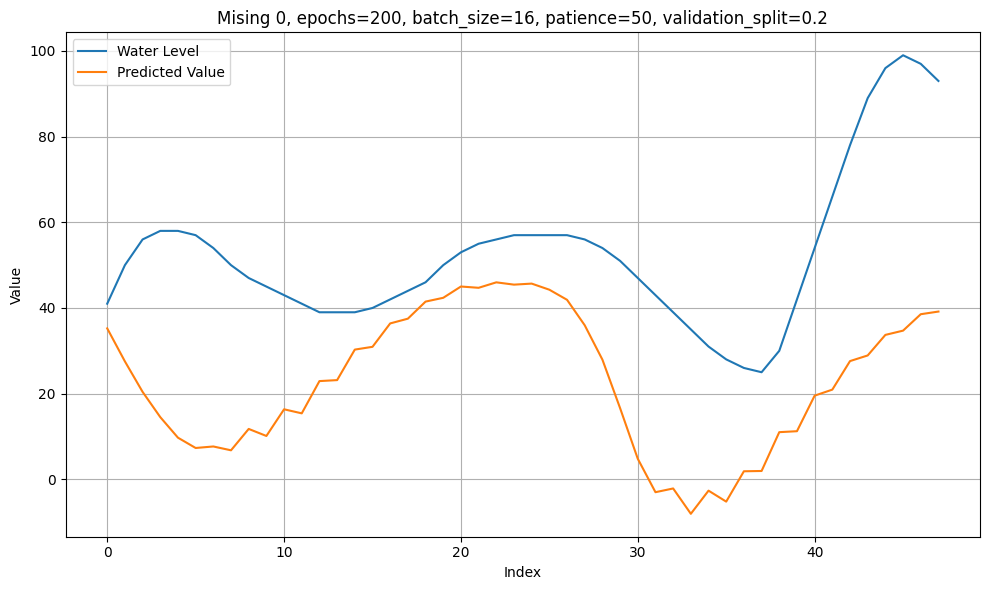


All values in df_miss is in the last !!!
Epoch 1/200
3198/3198 [==============================] - 24s 7ms/step - loss: 2709.2866 - mae: 24.5486 - val_loss: 53.0366 - val_mae: 5.3103
Epoch 2/200
3198/3198 [==============================] - 22s 7ms/step - loss: 100.5328 - mae: 7.5270 - val_loss: 34.9800 - val_mae: 4.6170
Epoch 3/200
3198/3198 [==============================] - 22s 7ms/step - loss: 73.6629 - mae: 6.3728 - val_loss: 33.4889 - val_mae: 4.5592
Epoch 4/200
3198/3198 [==============================] - 22s 7ms/step - loss: 60.8932 - mae: 5.7044 - val_loss: 23.7483 - val_mae: 3.5224
Epoch 5/200
3198/3198 [==============================] - 22s 7ms/step - loss: 56.8357 - mae: 5.4167 - val_loss: 44.2577 - val_mae: 5.0604
Epoch 6/200
3198/3198 [==============================] - 22s 7ms/step - loss: 50.3052 - mae: 5.1563 - val_loss: 29.1068 - val_mae: 4.1247
Epoch 7/200
3198/3198 [==============================] - 22s 7ms/step - loss: 47.0506 - mae: 4.9685 - val_loss: 28.9367 - val_

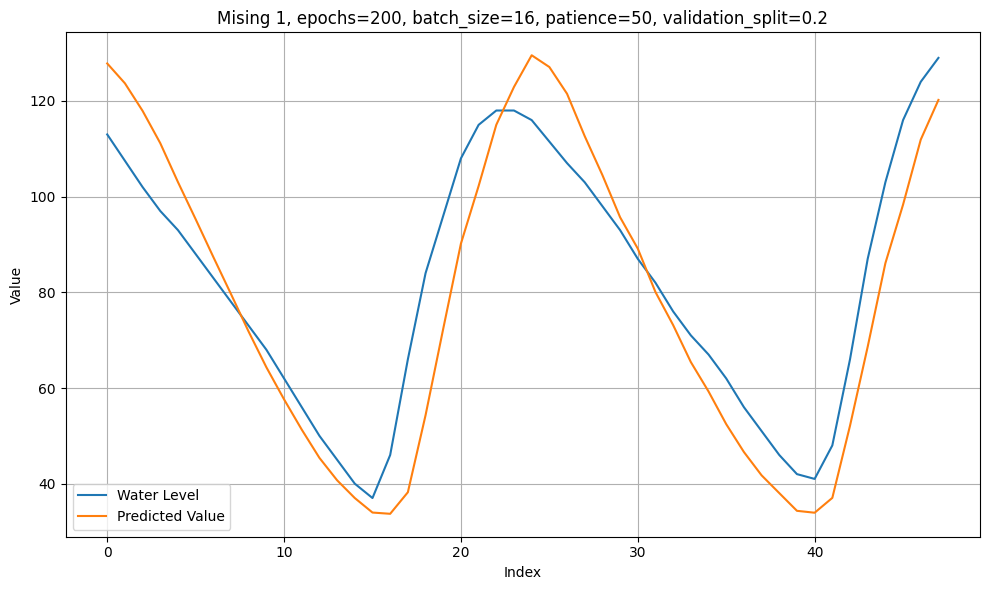

Epoch 1/200
2616/2616 [==============================] - 20s 7ms/step - loss: 5725.0303 - mae: 56.2662 - val_loss: 11097.7324 - val_mae: 73.2905
Epoch 2/200
2616/2616 [==============================] - 18s 7ms/step - loss: 4628.5908 - mae: 48.2677 - val_loss: 749.9026 - val_mae: 12.5010
Epoch 3/200
2616/2616 [==============================] - 18s 7ms/step - loss: 85.3899 - mae: 6.5403 - val_loss: 70.9391 - val_mae: 4.7739
Epoch 4/200
2616/2616 [==============================] - 18s 7ms/step - loss: 50.0274 - mae: 5.3132 - val_loss: 61.3844 - val_mae: 4.3219
Epoch 5/200
2616/2616 [==============================] - 18s 7ms/step - loss: 41.4602 - mae: 4.8267 - val_loss: 33.3688 - val_mae: 3.6590
Epoch 6/200
2616/2616 [==============================] - 18s 7ms/step - loss: 35.6615 - mae: 4.4568 - val_loss: 48.4438 - val_mae: 4.8662
Epoch 7/200
2616/2616 [==============================] - 18s 7ms/step - loss: 34.5653 - mae: 4.3248 - val_loss: 31.0410 - val_mae: 3.1357
Epoch 8/200
2616/2616 

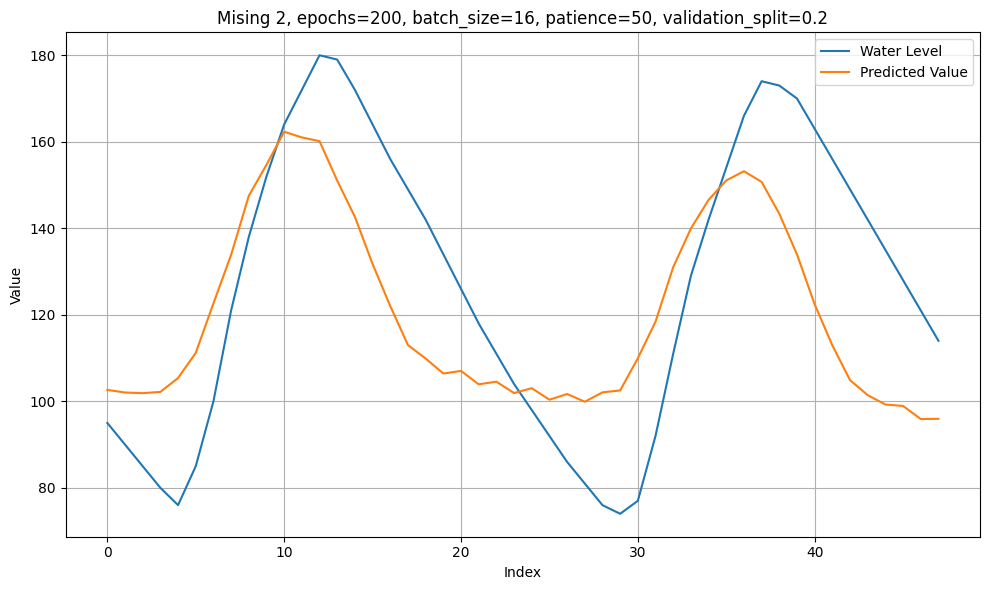

Epoch 1/200
8/8 [==============================] - 2s 65ms/step - loss: 7494.5352 - mae: 84.3822 - val_loss: 9771.1982 - val_mae: 96.0615
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 5774.6211 - mae: 73.4736 - val_loss: 8122.5845 - val_mae: 87.0945
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 4758.7686 - mae: 66.1658 - val_loss: 7025.2349 - val_mae: 80.5497
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 3927.7339 - mae: 59.4325 - val_loss: 5958.7607 - val_mae: 73.6328
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 3142.6143 - mae: 52.3581 - val_loss: 4941.2539 - val_mae: 66.3647
Epoch 6/200
8/8 [==============================] - 0s 13ms/step - loss: 2420.0964 - mae: 45.0710 - val_loss: 4009.8105 - val_mae: 58.9307
Epoch 7/200
8/8 [==============================] - 0s 12ms/step - loss: 1788.3918 - mae: 37.7341 - val_loss: 3178.1604 - val_mae: 51.3924
Epoch 8/200
8/8 [=================

<Figure size 640x480 with 0 Axes>

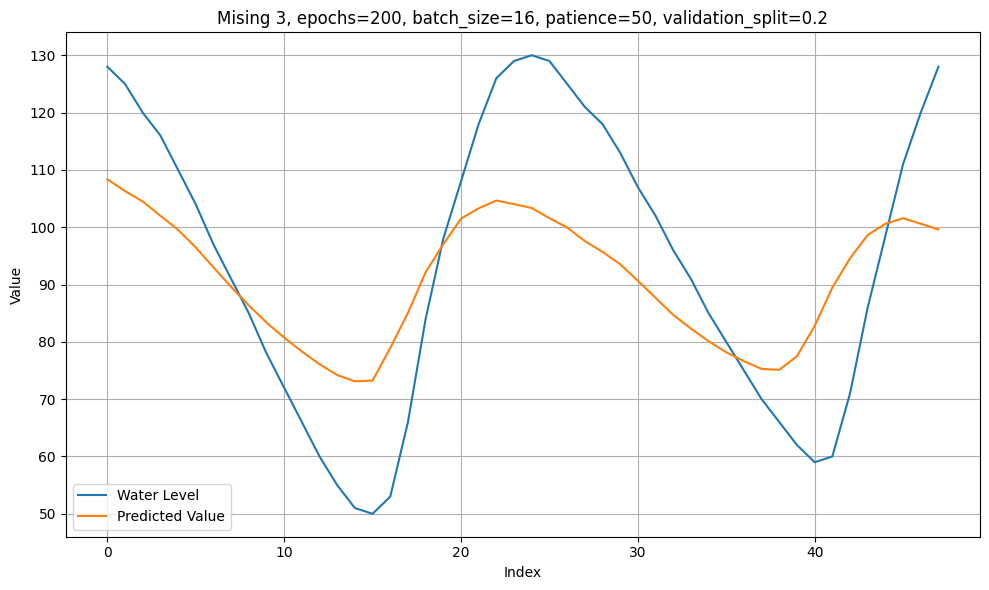

Epoch 1/200
2647/2647 [==============================] - 20s 7ms/step - loss: 5627.2173 - mae: 55.6476 - val_loss: 10810.4854 - val_mae: 74.0783
Epoch 2/200
2647/2647 [==============================] - 18s 7ms/step - loss: 4529.5830 - mae: 47.7436 - val_loss: 845.8218 - val_mae: 13.3483
Epoch 3/200
2647/2647 [==============================] - 18s 7ms/step - loss: 73.5395 - mae: 6.0423 - val_loss: 88.0003 - val_mae: 6.0365
Epoch 4/200
2647/2647 [==============================] - 18s 7ms/step - loss: 43.7682 - mae: 4.8630 - val_loss: 87.1025 - val_mae: 5.6503
Epoch 5/200
2647/2647 [==============================] - 18s 7ms/step - loss: 39.3024 - mae: 4.5796 - val_loss: 25.0872 - val_mae: 3.3819
Epoch 6/200
2647/2647 [==============================] - 18s 7ms/step - loss: 34.7015 - mae: 4.3394 - val_loss: 64.7160 - val_mae: 4.0985
Epoch 7/200
2647/2647 [==============================] - 18s 7ms/step - loss: 30.7483 - mae: 4.0697 - val_loss: 37.8245 - val_mae: 4.0439
Epoch 8/200
2647/2647 

<Figure size 640x480 with 0 Axes>

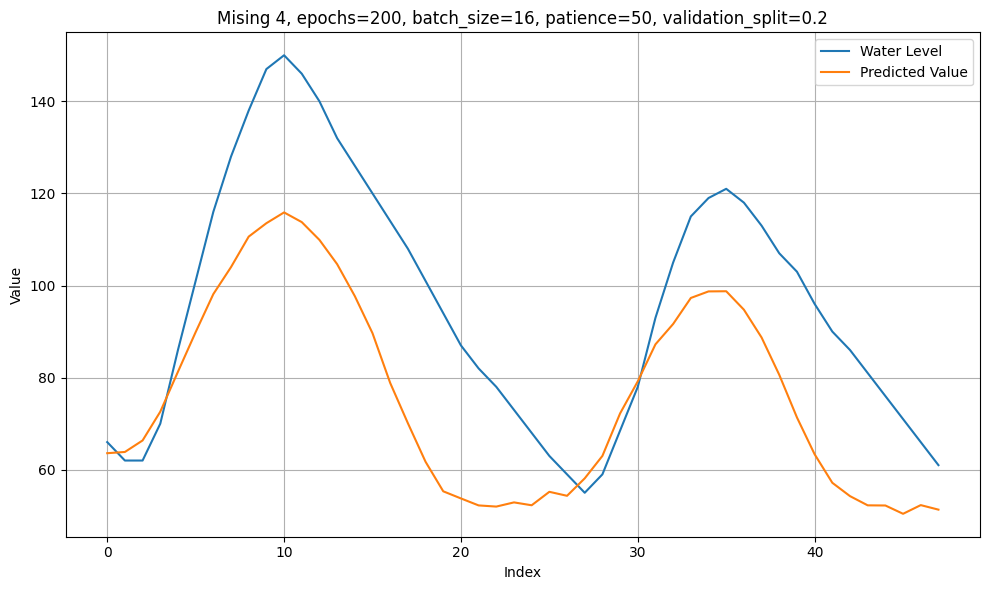

Epoch 1/200
943/943 [==============================] - 8s 8ms/step - loss: 5864.2212 - mae: 56.0267 - val_loss: 1841.1494 - val_mae: 33.1764
Epoch 2/200
943/943 [==============================] - 6s 7ms/step - loss: 419.2918 - mae: 12.0337 - val_loss: 60.6875 - val_mae: 5.4693
Epoch 3/200
943/943 [==============================] - 6s 7ms/step - loss: 62.0585 - mae: 5.8155 - val_loss: 26.4601 - val_mae: 4.1833
Epoch 4/200
943/943 [==============================] - 6s 7ms/step - loss: 46.9400 - mae: 5.1885 - val_loss: 41.7634 - val_mae: 5.1730
Epoch 5/200
943/943 [==============================] - 6s 7ms/step - loss: 45.2243 - mae: 5.0096 - val_loss: 35.6227 - val_mae: 5.0355
Epoch 6/200
943/943 [==============================] - 6s 7ms/step - loss: 40.2561 - mae: 4.7486 - val_loss: 14.3496 - val_mae: 2.6850
Epoch 7/200
943/943 [==============================] - 6s 7ms/step - loss: 36.9517 - mae: 4.5291 - val_loss: 22.7200 - val_mae: 3.3954
Epoch 8/200
943/943 [==========================

<Figure size 640x480 with 0 Axes>

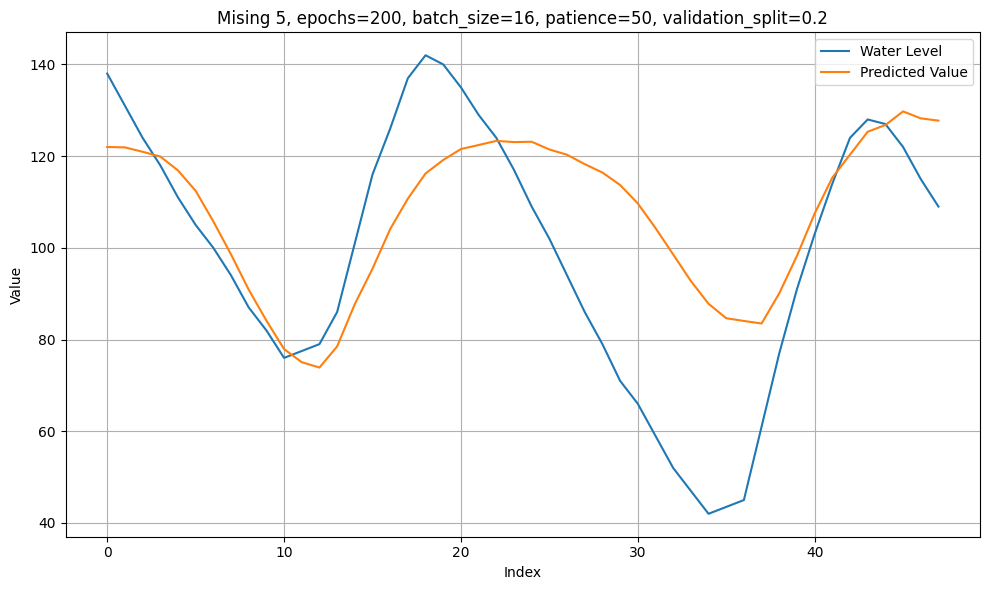

Epoch 1/200
826/826 [==============================] - 7s 7ms/step - loss: 3749.9163 - mae: 46.9969 - val_loss: 16826.2617 - val_mae: 103.2680
Epoch 2/200
826/826 [==============================] - 5s 6ms/step - loss: 3244.6436 - mae: 44.2011 - val_loss: 16264.7490 - val_mae: 100.7862
Epoch 3/200
826/826 [==============================] - 5s 6ms/step - loss: 3257.1401 - mae: 44.2944 - val_loss: 17068.4863 - val_mae: 104.3314
Epoch 4/200
826/826 [==============================] - 5s 6ms/step - loss: 3249.3140 - mae: 44.2554 - val_loss: 15693.0771 - val_mae: 98.2342
Epoch 5/200
826/826 [==============================] - 5s 6ms/step - loss: 3251.5427 - mae: 44.2591 - val_loss: 16030.0771 - val_mae: 99.7408
Epoch 6/200
826/826 [==============================] - 5s 6ms/step - loss: 3256.0142 - mae: 44.2959 - val_loss: 16985.2559 - val_mae: 103.9669
Epoch 7/200
826/826 [==============================] - 5s 6ms/step - loss: 3251.3079 - mae: 44.2262 - val_loss: 17390.2676 - val_mae: 105.7355
E

<Figure size 640x480 with 0 Axes>

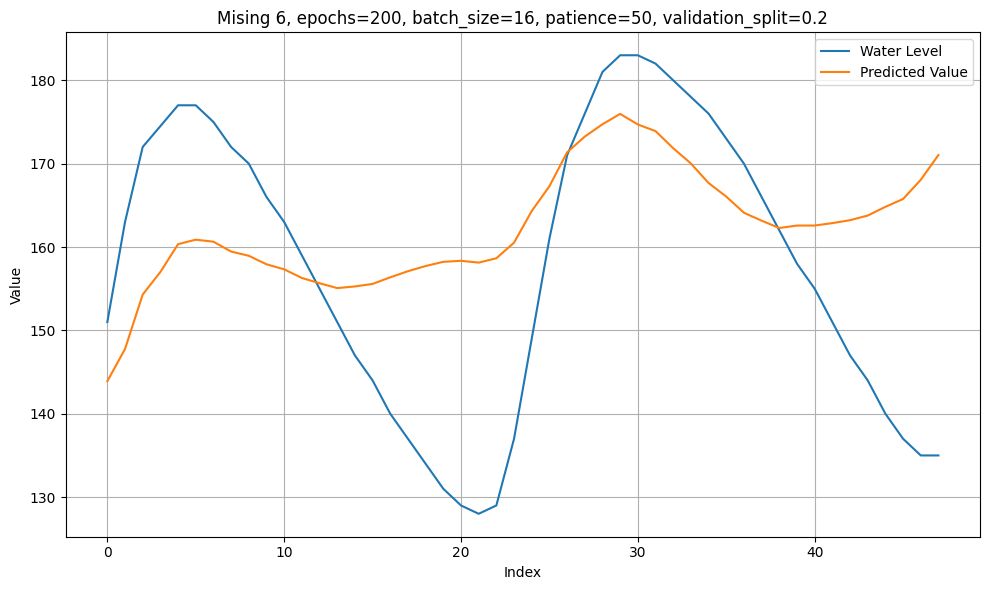

Epoch 1/200
1558/1558 [==============================] - 13s 7ms/step - loss: 6796.4233 - mae: 59.4585 - val_loss: 1320.6589 - val_mae: 29.7176
Epoch 2/200
1558/1558 [==============================] - 11s 7ms/step - loss: 404.2283 - mae: 12.1529 - val_loss: 34.5246 - val_mae: 4.3826
Epoch 3/200
1558/1558 [==============================] - 11s 7ms/step - loss: 81.4811 - mae: 6.7460 - val_loss: 29.0749 - val_mae: 4.1315
Epoch 4/200
1558/1558 [==============================] - 10s 7ms/step - loss: 67.7125 - mae: 6.1376 - val_loss: 27.2394 - val_mae: 3.9648
Epoch 5/200
1558/1558 [==============================] - 10s 7ms/step - loss: 56.3527 - mae: 5.6374 - val_loss: 15.1264 - val_mae: 2.8706
Epoch 6/200
1558/1558 [==============================] - 11s 7ms/step - loss: 48.8841 - mae: 5.2844 - val_loss: 15.5789 - val_mae: 3.0746
Epoch 7/200
1558/1558 [==============================] - 11s 7ms/step - loss: 45.6033 - mae: 5.0702 - val_loss: 25.6648 - val_mae: 3.9146
Epoch 8/200
1558/1558 [===

<Figure size 640x480 with 0 Axes>

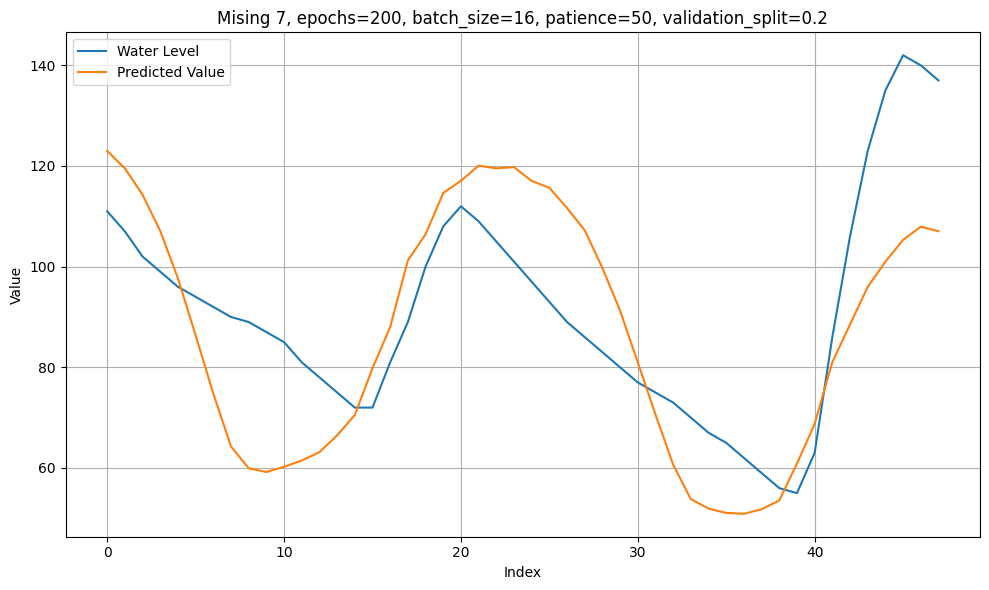

Epoch 1/200
2751/2751 [==============================] - 21s 7ms/step - loss: 5566.7925 - mae: 55.2255 - val_loss: 10679.5527 - val_mae: 72.2235
Epoch 2/200
2751/2751 [==============================] - 19s 7ms/step - loss: 5314.3364 - mae: 54.0581 - val_loss: 10641.0898 - val_mae: 72.4440
Epoch 3/200
2751/2751 [==============================] - 19s 7ms/step - loss: 5308.0098 - mae: 53.9990 - val_loss: 10573.9551 - val_mae: 72.9554
Epoch 4/200
2751/2751 [==============================] - 20s 7ms/step - loss: 5311.5132 - mae: 54.0480 - val_loss: 10586.8076 - val_mae: 72.8391
Epoch 5/200
2751/2751 [==============================] - 19s 7ms/step - loss: 5311.2891 - mae: 54.0462 - val_loss: 10743.8066 - val_mae: 71.9301
Epoch 6/200
2751/2751 [==============================] - 19s 7ms/step - loss: 5308.0000 - mae: 54.0159 - val_loss: 10560.3203 - val_mae: 73.0915
Epoch 7/200
2751/2751 [==============================] - 19s 7ms/step - loss: 5310.8960 - mae: 54.0499 - val_loss: 10613.5830 - va

<Figure size 640x480 with 0 Axes>

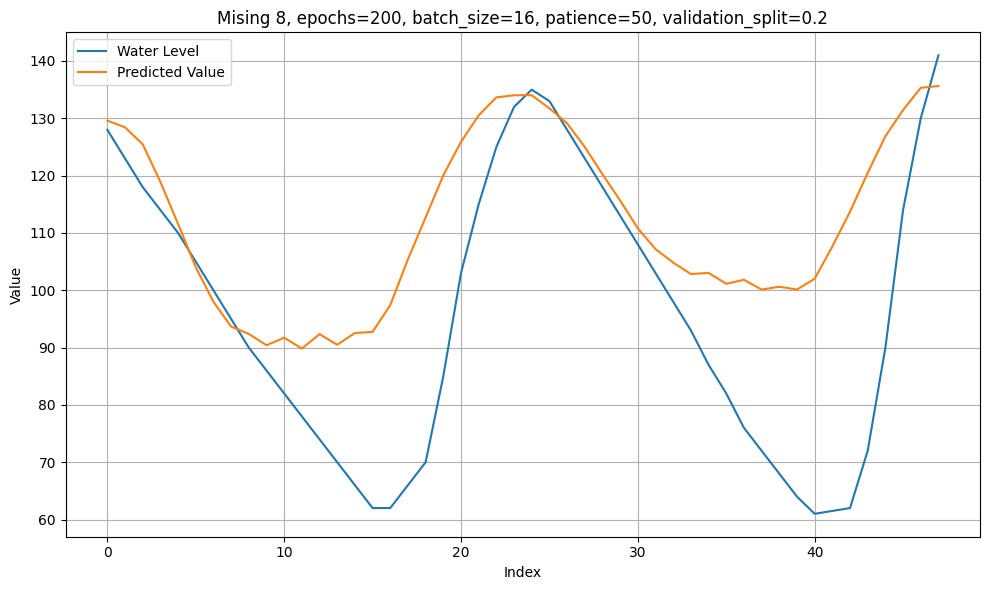

Epoch 1/200
146/146 [==============================] - 3s 12ms/step - loss: 2366.5928 - mae: 38.6903 - val_loss: 1347.0193 - val_mae: 30.9064
Epoch 2/200
146/146 [==============================] - 1s 8ms/step - loss: 1375.0161 - mae: 30.3442 - val_loss: 1373.9301 - val_mae: 31.2453
Epoch 3/200
146/146 [==============================] - 1s 7ms/step - loss: 1379.6541 - mae: 30.4190 - val_loss: 1366.7953 - val_mae: 31.1528
Epoch 4/200
146/146 [==============================] - 1s 8ms/step - loss: 1378.8741 - mae: 30.3392 - val_loss: 1381.4104 - val_mae: 31.3382
Epoch 5/200
146/146 [==============================] - 1s 8ms/step - loss: 1377.5858 - mae: 30.3941 - val_loss: 1345.7435 - val_mae: 30.8857
Epoch 6/200
146/146 [==============================] - 1s 8ms/step - loss: 1379.3617 - mae: 30.4082 - val_loss: 1364.5593 - val_mae: 31.1283
Epoch 7/200
146/146 [==============================] - 1s 7ms/step - loss: 1378.7449 - mae: 30.3850 - val_loss: 1344.3525 - val_mae: 30.8270
Epoch 8/200


<Figure size 640x480 with 0 Axes>

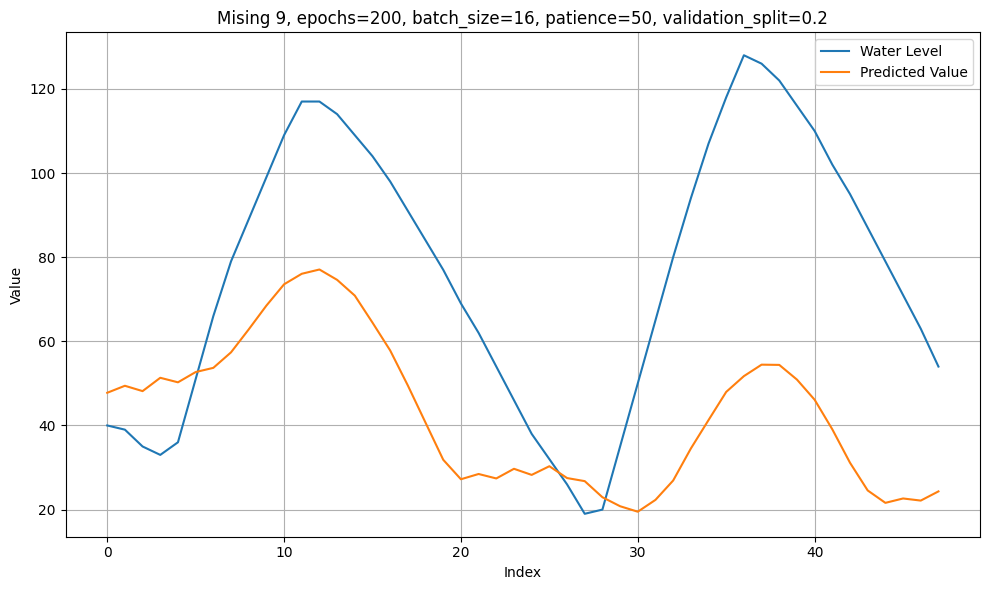

Epoch 1/200
1960/1960 [==============================] - 16s 7ms/step - loss: 4475.7739 - mae: 44.4977 - val_loss: 54.4616 - val_mae: 5.8342
Epoch 2/200
1960/1960 [==============================] - 14s 7ms/step - loss: 94.7049 - mae: 6.9361 - val_loss: 21.1726 - val_mae: 3.5942
Epoch 3/200
1960/1960 [==============================] - 14s 7ms/step - loss: 59.4437 - mae: 5.6904 - val_loss: 66.8008 - val_mae: 6.7158
Epoch 4/200
1960/1960 [==============================] - 14s 7ms/step - loss: 51.3617 - mae: 5.2932 - val_loss: 12.1619 - val_mae: 2.6166
Epoch 5/200
1960/1960 [==============================] - 13s 7ms/step - loss: 44.5241 - mae: 4.8855 - val_loss: 47.0939 - val_mae: 6.1656
Epoch 6/200
1960/1960 [==============================] - 13s 7ms/step - loss: 42.8885 - mae: 4.8107 - val_loss: 16.3459 - val_mae: 2.9730
Epoch 7/200
1960/1960 [==============================] - 14s 7ms/step - loss: 40.6073 - mae: 4.5990 - val_loss: 10.9195 - val_mae: 2.4644
Epoch 8/200
1960/1960 [========

<Figure size 640x480 with 0 Axes>

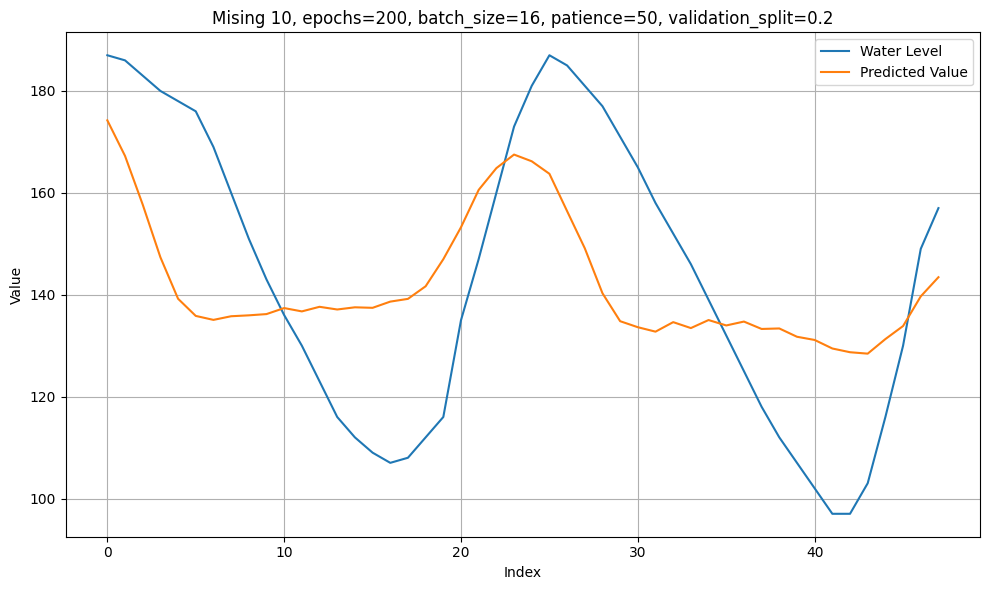

Epoch 1/200
457/457 [==============================] - 5s 8ms/step - loss: 5401.1211 - mae: 56.7889 - val_loss: 1130.0480 - val_mae: 27.2428
Epoch 2/200
457/457 [==============================] - 3s 7ms/step - loss: 3095.3223 - mae: 42.5654 - val_loss: 607.2354 - val_mae: 20.8372
Epoch 3/200
457/457 [==============================] - 3s 7ms/step - loss: 223.9255 - mae: 9.6592 - val_loss: 25.9129 - val_mae: 4.0111
Epoch 4/200
457/457 [==============================] - 3s 7ms/step - loss: 79.7173 - mae: 6.6706 - val_loss: 19.2937 - val_mae: 3.4128
Epoch 5/200
457/457 [==============================] - 3s 7ms/step - loss: 61.1469 - mae: 6.0096 - val_loss: 21.9506 - val_mae: 3.7459
Epoch 6/200
457/457 [==============================] - 3s 7ms/step - loss: 54.5665 - mae: 5.6369 - val_loss: 17.3766 - val_mae: 3.1352
Epoch 7/200
457/457 [==============================] - 3s 7ms/step - loss: 47.9415 - mae: 5.2426 - val_loss: 62.3559 - val_mae: 6.9785
Epoch 8/200
457/457 [======================

<Figure size 640x480 with 0 Axes>

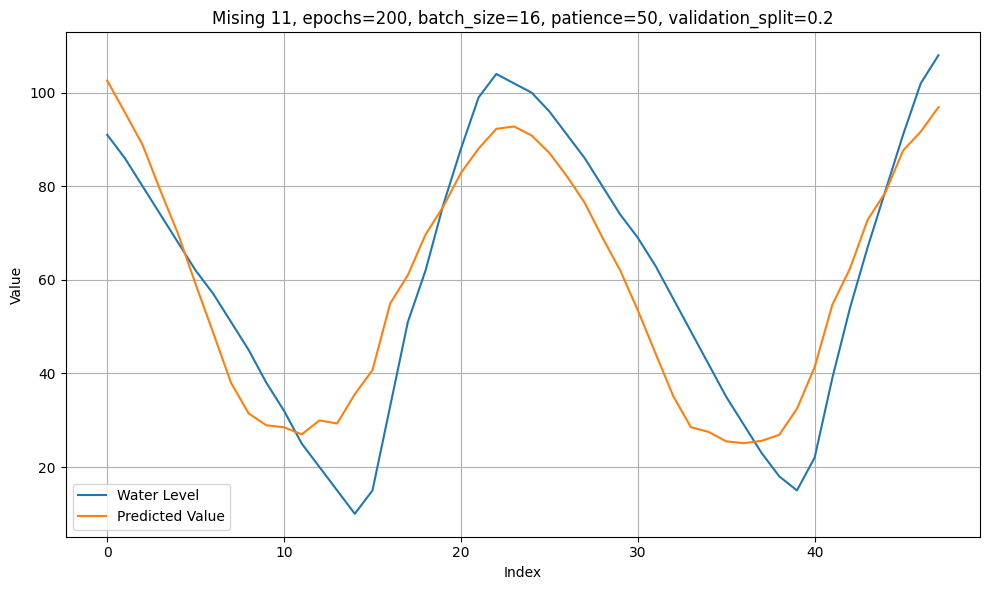




Mean of Similarity combine:  0.8374479407038246

Mean of Mean Absoulute Error combine : 18.82169438965826

Mean of Root Mean Squared Error combine:  22.370124440925505

Mean of Fraction of Standard Deviation combine:  0.445340931747985

Mean of R-score combine:  0.7144456504057782

Mean of the Nash Sutcliffe efficiency (NSE):  0.057707152766758064




<Figure size 640x480 with 0 Axes>

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'P:\SU24\Imputation\HY_git\waterlevel_missing\waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,64,64'
        filename = f'128,256,512,64,64, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,64,64'
        filename = f'128,256,512,64,64, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()    
        folder_path = 'P:\SU24\Imputation\HY_git\\128,256,512,64,64'
        filename = f'128,256,512,64,64, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

### epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')